In [1]:
import torch
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from AlexNet import (
    AlexNet,
    get_train_transform,
    compute_dataset_mean,
    compute_dataset_std,
    get_optimizer,
    adjust_learning_rate
)

c:\Users\Quyen\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


# output
cpu

In [ ]:
# model summary
from torchsummary import summary
device = torch.device("cpu") # cuda if run on gpu
model = AlexNet(num_classes=1000).to(device)
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 55, 55]          34,944
              ReLU-2           [-1, 96, 55, 55]               0
 LocalResponseNorm-3           [-1, 96, 55, 55]               0
         MaxPool2d-4           [-1, 96, 27, 27]               0
            Conv2d-5          [-1, 256, 27, 27]         614,656
              ReLU-6          [-1, 256, 27, 27]               0
 LocalResponseNorm-7          [-1, 256, 27, 27]               0
         MaxPool2d-8          [-1, 256, 13, 13]               0
            Conv2d-9          [-1, 384, 13, 13]         885,120
             ReLU-10          [-1, 384, 13, 13]               0
           Conv2d-11          [-1, 384, 13, 13]       1,327,488
             ReLU-12          [-1, 384, 13, 13]               0
           Conv2d-13          [-1, 256, 13, 13]         884,992
             ReLU-14          [-1, 256,

# output
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
================================================================
            Conv2d-1           [-1, 96, 55, 55]          34,944
              ReLU-2           [-1, 96, 55, 55]               0
 LocalResponseNorm-3           [-1, 96, 55, 55]               0
         MaxPool2d-4           [-1, 96, 27, 27]               0
            Conv2d-5          [-1, 256, 27, 27]         614,656
              ReLU-6          [-1, 256, 27, 27]               0
 LocalResponseNorm-7          [-1, 256, 27, 27]               0
         MaxPool2d-8          [-1, 256, 13, 13]               0
            Conv2d-9          [-1, 384, 13, 13]         885,120
             ReLU-10          [-1, 384, 13, 13]               0
           Conv2d-11          [-1, 384, 13, 13]       1,327,488
             ReLU-12          [-1, 384, 13, 13]               0
           Conv2d-13          [-1, 256, 13, 13]         884,992
             ReLU-14          [-1, 256, 13, 13]               0
        MaxPool2d-15            [-1, 256, 6, 6]               0
          Dropout-16                 [-1, 9216]               0
           Linear-17                 [-1, 4096]      37,752,832
             ReLU-18                 [-1, 4096]               0
          Dropout-19                 [-1, 4096]               0
           Linear-20                 [-1, 4096]      16,781,312
             ReLU-21                 [-1, 4096]               0
           Linear-22                 [-1, 1000]       4,097,000
================================================================
Total params: 62,378,344
Trainable params: 62,378,344
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 14.73
Params size (MB): 237.95
Estimated Total Size (MB): 253.26
----------------------------------------------------------------

In [ ]:
# Step 1: Compute mean and std
base_dataset = datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transforms.ToTensor()
)
mean = compute_dataset_mean(base_dataset)
std = compute_dataset_std(base_dataset)
print(f"Computed mean: {mean}")
print(f"Computed std: {std}")

# Output
Computed mean: [0.4913999140262604, 0.4821586608886719, 0.44653135538101196]
Computed std: [0.2023008167743683, 0.19941279292106628, 0.20096156001091003]

In [ ]:
# Step 2: Define transforms
train_transform = get_train_transform(mean, std)

In [ ]:
# Step 3: Prepare dataset and loader
full_dataset = datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=train_transform
)

# split into training and validation (90% for train: 45K train, 5K val)
train_size = int(0.9 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=2)

In [ ]:
# Step 4: Initialize model
model = AlexNet(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = get_optimizer(model)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

In [ ]:
# Step 5: Training loop
num_epochs = 15 # for 10 epochs take 5.5 hours for training 

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    scheduler.step()

    train_loss = running_loss / total
    train_acc = 100 * correct / total

    print(f"Epoch {epoch+1:03d}: Train Loss={train_loss:.4f}, Train Acc={train_acc:.2f}%")

    # validation step
    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for val_inputs, val_targets in val_loader:
            val_inputs, val_targets = val_inputs.to(device), val_targets.to(device)
            val_outputs = model(val_inputs)
            _, val_predicted = val_outputs.max(1)
            val_total += val_targets.size(0)
            val_correct += val_predicted.eq(val_targets).sum().item()
    val_acc = 100 * val_correct / val_total
    print(f"           Validation Acc={val_acc:.2f}%")

# Output
Epoch 001: Train Loss=2.2396, Train Acc=14.42%
           Validation Acc=24.90%
Epoch 002: Train Loss=1.7828, Train Acc=33.82%
           Validation Acc=43.26%
Epoch 003: Train Loss=1.4541, Train Acc=46.26%
           Validation Acc=52.54%
Epoch 004: Train Loss=1.2580, Train Acc=54.36%
           Validation Acc=59.62%
Epoch 005: Train Loss=1.1046, Train Acc=60.69%
           Validation Acc=64.16%
Epoch 006: Train Loss=0.9776, Train Acc=65.26%
           Validation Acc=69.72%
Epoch 007: Train Loss=0.8583, Train Acc=69.88%
           Validation Acc=72.24%
Epoch 008: Train Loss=0.7736, Train Acc=72.83%
           Validation Acc=75.84%
Epoch 009: Train Loss=0.7113, Train Acc=75.07%
           Validation Acc=76.06%
Epoch 010: Train Loss=0.6664, Train Acc=76.72%
           Validation Acc=77.88%
Epoch 011: Train Loss=0.6163, Train Acc=78.65%
           Validation Acc=77.80%
Epoch 012: Train Loss=0.5737, Train Acc=80.07%
           Validation Acc=81.22%
Epoch 013: Train Loss=0.5377, Train Acc=81.32%
           Validation Acc=81.84%
Epoch 014: Train Loss=0.4994, Train Acc=82.58%
           Validation Acc=82.08%
Epoch 015: Train Loss=0.4809, Train Acc=83.20%
           Validation Acc=82.88%

In [ ]:
# Step 6: Save model
torch.save(model.state_dict(), "alexnet_cifar10.pth")
print("Model saved to alexnet_cifar10.pth")

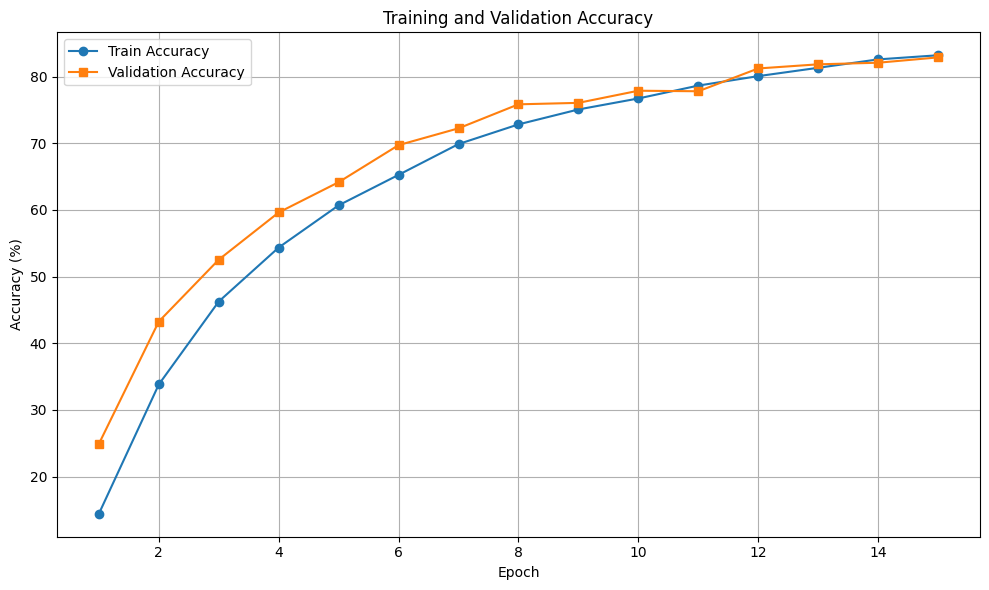

In [4]:
# plot train acc vs validation acc
import matplotlib.pyplot as plt

# Data
epochs = list(range(1, 16))
train_acc = [14.42, 33.82, 46.26, 54.36, 60.69, 65.26, 69.88, 72.83,
             75.07, 76.72, 78.65, 80.07, 81.32, 82.58, 83.2]
val_acc = [24.90, 43.26, 52.54, 59.62, 64.16, 69.72, 72.24, 75.84,
           76.06, 77.88, 77.80, 81.22, 81.84, 82.08, 82.88]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_acc, 'o-', label='Train Accuracy')
plt.plot(epochs, val_acc, 's-', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

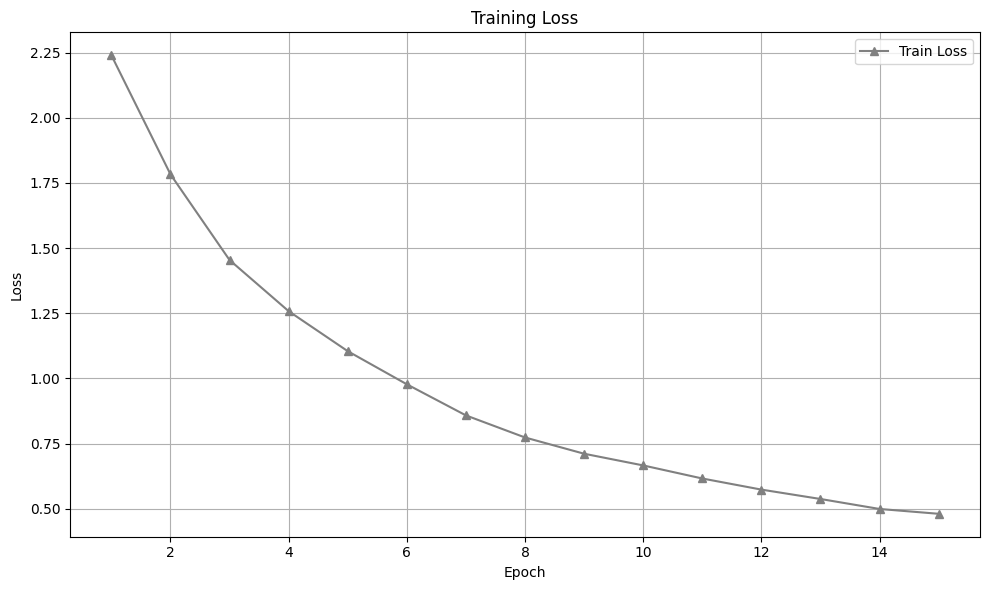

In [5]:
# plot train loss
import matplotlib.pyplot as plt

# Data
train_loss = [2.2396, 1.7828, 1.4541, 1.2580, 1.1046, 0.9776,
              0.8583, 0.7736, 0.7113, 0.6664, 0.6163, 0.5737,
              0.5377, 0.4994, 0.4809]

# Define epochs
epochs = list(range(1, len(train_loss) + 1))

# Plot
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, '^-', color='gray', label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
